In [1]:
import arviz as az
import pandas as pd
import json

import numpy as np
import diffrax
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import sys
from scipy.stats import mode

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('custom')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
sys.path.insert(0, '/home/nlinden/.matplotlib/')
from plotting_helper_funcs import *

# custom plotting helper funcs
sys.path.insert(0, '../')
from plotting_helper_funcs import *
from utils import *

rng = np.random.default_rng(seed=1234)

%env CUDA_VISIBLE_DEVICES=1

datadir = '../../../results/MAPK/param_est/Keyes_2020_data/CYTO/'

# path to save figures/output
fig_dir = '../../../results/MAPK/mmi/Keyes_2020_data/model_perturb/CYTO/'

# add fig_dir if it does not exist
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


env: CUDA_VISIBLE_DEVICES=1


Now load in all of the posterior idata and the posterior predictive samples...

In [2]:
# Huang and Ferrell 1996
HF_1996_idata, HF_1996_ss = load_smc_samples_to_idata(datadir + 'huang_ferrell_1996/huang_ferrell_1996_smc_samples.json')
HF_1996_post = np.load(datadir + 'huang_ferrell_1996/traj_predict.npy')
# Kholodenko 2000
K_2000_idata, K_2000_ss = load_smc_samples_to_idata(datadir + 'kholodenko_2000/kholodenko_2000_smc_samples.json')
K_2000_post = np.load(datadir + 'kholodenko_2000/traj_predict.npy')
# Levchenko 2000
L_2000_idata, L_2000_ss = load_smc_samples_to_idata(datadir + 'levchenko_2000/levchenko_2000_smc_samples.json')
L_2000_post = np.load(datadir + 'levchenko_2000/traj_predict.npy')
# Hornberg 2005
H_2005_idata, H_2005_ss = load_smc_samples_to_idata(datadir + 'hornberg_2005/hornberg_2005_smc_samples.json')
H_2005_post = np.load(datadir + 'hornberg_2005/traj_predict.npy')
# Birtwistle 2007
B_2007_idata, B_2007_ss = load_smc_samples_to_idata(datadir + 'birtwistle_2007/birtwistle_2007_smc_samples.json')
B_2007_post = np.load(datadir + 'birtwistle_2007/traj_predict.npy')
# Orton 2009
O_2009_idata, O_2009_ss = load_smc_samples_to_idata(datadir + 'orton_2009/orton_2009_smc_samples.json')
O_2009_post = np.load(datadir + 'orton_2009/traj_predict.npy')
# von Kreigsheim 2009
vK_2009_idata, VK_2009_ss= load_smc_samples_to_idata(datadir + 'vonKriegsheim_2009/vonKriegsheim_2009_smc_samples.json')
vK_2009_post = np.load(datadir + 'vonKriegsheim_2009/traj_predict.npy')
# Shin 2014
S_2014_idata, S_2014_ss = load_smc_samples_to_idata(datadir + 'shin_2014/shin_2014_smc_samples.json')
S_2014_post = np.load(datadir + 'shin_2014/traj_predict.npy')
# Ryu 2015
R_2015_idata, R_2015_ss = load_smc_samples_to_idata(datadir + 'ryu_2015/ryu_2015_smc_samples.json')
R_2015_post = np.load(datadir + 'ryu_2015/traj_predict.npy')
# Kochańczyk 2017
K_2017_idata, K_2017_ss = load_smc_samples_to_idata(datadir + 'kochanczyk_2017/kochanczyk_2017_smc_samples.json')
K_2017_post = np.load(datadir + 'kochanczyk_2017/traj_predict.npy')

# Log marginal likelihoods
S_2014_log_magr = np.mean([chain[-1] for chain in S_2014_ss['log_marginal_likelihood']])
K_2000_log_magr = np.mean([chain[-1] for chain in K_2000_ss['log_marginal_likelihood'][0]])
vK_2009_log_magr = np.mean([chain[-1] for chain in VK_2009_ss['log_marginal_likelihood']])
O_2009_log_magr = np.mean([chain[-1] for chain in O_2009_ss['log_marginal_likelihood']])
R_2015_log_magr = np.mean([chain[-1] for chain in R_2015_ss['log_marginal_likelihood'][0]])
L_2000_log_magr = np.mean([chain[-1] for chain in L_2000_ss['log_marginal_likelihood'][0]])
K_2017_log_magr = np.mean([chain[-1] for chain in K_2017_ss['log_marginal_likelihood']])
B_2007_log_magr = np.mean([chain[-1] for chain in B_2007_ss['log_marginal_likelihood'][0]])
H_2005_log_magr = np.mean([chain[-1] for chain in H_2005_ss['log_marginal_likelihood'][0]])
HF_1996_log_magr = np.mean([chain[-1] for chain in HF_1996_ss['log_marginal_likelihood']])

# get data
inputs, data, data_std, times = load_data_json('../../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-CYTO.json', data_std=True, time=True)

# set up a color palette
# this is the ColorBrewer purple-green with 11 colors + three greys https://colorbrewer2.org/#type=diverging&scheme=PRGn&n=11
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b','#363737','#929591','#d8dcd6']
# this one gets to 10 colors by removing the darkest purple
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#363737','#929591','#d8dcd6']
orange = '#de8f05'

colors = get_color_pallette()

Now we want to construct three MMI predictors:
1. All models
2. Exclude the worst model - *Hatakeyama 2003*
3. Exclude the best model - *Kochanczyk 2017*

In [3]:
# function to compute model probs
def logsumexp(x):
        c = np.max(x)
        return c + np.log(np.sum(np.exp(x - c)))

def weight_with_logsumexp(log_values):
    return np.exp(log_values - logsumexp(log_values))

def model_probs(log_marginal_likes):
    """Computes the model probabilities from a list of log marginal likelihoods."""

    n_models = len(log_marginal_likes)
    prior_prob = 1/n_models
    model_probs = weight_with_logsumexp(np.log(prior_prob)+log_marginal_likes)
    

    return model_probs

In [4]:
# for all model case
model_names_all = ['huang_ferrell_1996', 'kholodenko_2000', 'levchenko_2000','hornberg_2005', 'birtwistle_2007','orton_2009', 'vonKriegsheim_2009', 'shin_2014', 'ryu_2015', 'kochanczyk_2017']
display_names_all = ["HF' 1996", "K' 2000", "L' 2000", "H' 2005", "B' 2007","O' 2009", "vK' 2009", "S' 2014", "R' 2015", "K' 2017"]
log_marginal_likes_all_dict = {'huang_ferrell_1996': HF_1996_log_magr,
                               'kholodenko_2000': K_2000_log_magr, 
                               'levchenko_2000': L_2000_log_magr, 
                               'hornberg_2005': H_2005_log_magr, 
                               'birtwistle_2007': B_2007_log_magr, 
                               'orton_2009': O_2009_log_magr, 
                               'vonKriegsheim_2009': vK_2009_log_magr, 
                               'shin_2014': S_2014_log_magr, 
                               'ryu_2015': R_2015_log_magr, 
                               'kochanczyk_2017': K_2017_log_magr}
log_marginal_likes_all = np.array([log_marginal_likes_all_dict[model] for model in model_names_all])
dict_compare_all = {'huang_ferrell_1996': HF_1996_idata, 'kholodenko_2000': K_2000_idata, 'levchenko_2000':L_2000_idata,'hornberg_2005':H_2005_idata,'birtwistle_2007':B_2007_idata,'orton_2009':O_2009_idata, 'vonKriegsheim_2009':vK_2009_idata, 'shin_2014': S_2014_idata, 'ryu_2015': R_2015_idata, 'kochanczyk_2017':K_2017_idata}

compare_data_loo_pbma_all = az.compare(dict_compare_all, ic='loo', method='BB-pseudo-BMA')
compare_data_loo_stack_all = az.compare(dict_compare_all, ic='loo', method='stacking')
model_probs_all = model_probs(log_marginal_likes_all)
stack_weight_all = [compare_data_loo_stack_all.loc[model]['weight'] for model in model_names_all]
pBMA_weight_all = [compare_data_loo_pbma_all.loc[model]['weight'] for model in model_names_all]

posterior_samples_all_dict = {'huang_ferrell_1996': HF_1996_post,
                              'kholodenko_2000': K_2000_post, 
                              'levchenko_2000': L_2000_post, 
                              'hornberg_2005': H_2005_post, 
                              'birtwistle_2007': B_2007_post, 
                              'orton_2009': O_2009_post, 
                              'vonKriegsheim_2009': vK_2009_post, 
                              'shin_2014': S_2014_post, 
                              'ryu_2015': R_2015_post, 
                              'kochanczyk_2017': K_2017_post}
posterior_samples_all = [posterior_samples_all_dict[model] for model in model_names_all]

# exclude best model - Orton 2009
to_exclude = 'orton_2009'
to_exclude_disp = "O' 2009"
model_names_ExclGood = [name for name in model_names_all if name != to_exclude]
display_names_ExclGood = [name for name in display_names_all if name != to_exclude_disp]
log_marginal_likes_ExclGood = np.array([log_marginal_likes_all_dict[model] for model in model_names_ExclGood])
dict_compare_ExclGood = {model: dict_compare_all[model] for model in model_names_ExclGood}

compare_data_loo_pbma_ExclGood = az.compare(dict_compare_ExclGood, ic='loo', method='BB-pseudo-BMA')
compare_data_loo_stack_ExclGood = az.compare(dict_compare_ExclGood, ic='loo', method='stacking')
model_probs_ExclGood = model_probs(log_marginal_likes_ExclGood)
stack_weight_ExclGood = [compare_data_loo_stack_ExclGood.loc[model]['weight'] for model in model_names_ExclGood]
pBMA_weight_ExclGood = [compare_data_loo_pbma_ExclGood.loc[model]['weight'] for model in model_names_ExclGood]

posterior_samples_ExclGood = [posterior_samples_all_dict[model] for model in model_names_ExclGood]

# # # excluding worst model - Ryu 2015
to_exclude = 'ryu_2015'
to_exclude_disp = "R' 2015"
model_names_ExclBad = [name for name in model_names_all if name != to_exclude]
display_names_ExclBad = [name for name in display_names_all if name != to_exclude_disp]
log_marginal_likes_ExclBad = np.array([log_marginal_likes_all_dict[model] for model in model_names_ExclBad])
dict_compare_ExclBad = {model: dict_compare_all[model] for model in model_names_ExclBad}

compare_data_loo_pbma_ExclBad = az.compare(dict_compare_ExclBad, ic='loo', method='BB-pseudo-BMA')
compare_data_loo_stack_ExclBad = az.compare(dict_compare_ExclBad, ic='loo', method='stacking')
model_probs_ExclBad = model_probs(log_marginal_likes_ExclBad)
stack_weight_ExclBad = [compare_data_loo_stack_ExclBad.loc[model]['weight'] for model in model_names_ExclBad]
pBMA_weight_ExclBad = [compare_data_loo_pbma_ExclBad.loc[model]['weight'] for model in model_names_ExclBad]

posterior_samples_ExclBad = [posterior_samples_all_dict[model] for model in model_names_ExclBad]

/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to 

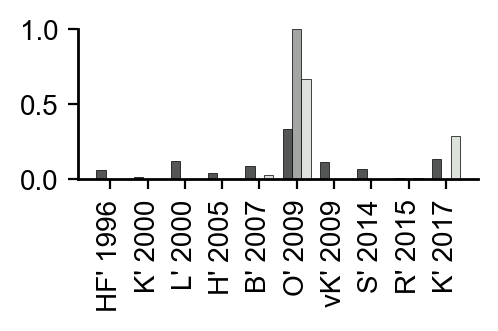

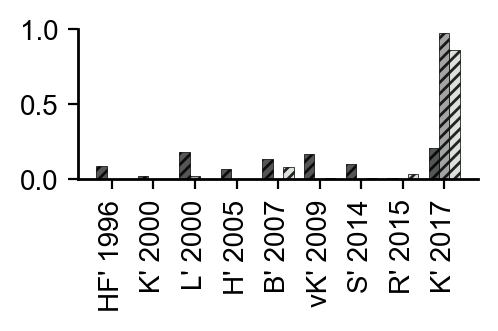

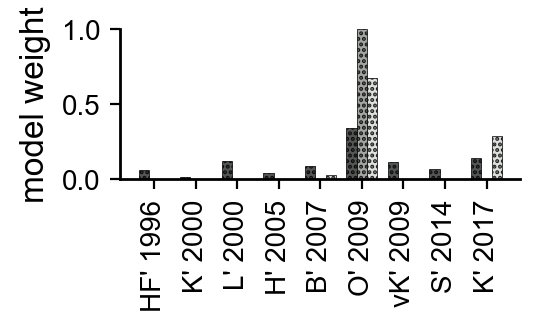

In [11]:
def make_weight_plot(pBMA, stack, model_probs, display_names, colors, filename=None,
                     ylabel='model weight', ax_width=2.5, ax_height=1., hatch=None):
    
    x = np.arange(len(display_names))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = get_sized_fig_ax(ax_width, ax_height)
    for dat, name, col in zip([pBMA, stack, model_probs], ['pBMA','stacking','BMA',], [colors[-3], colors[-2], colors[-1]]):
        offset = width * multiplier
        bar = ax.bar(x + offset, dat, width, label=name, color=col, edgecolor='k', hatch=hatch, alpha=0.85)
        # ax.bar_label(bar, padding=3)
        multiplier += 1

    ax.set_xticks(x + width, display_names)
    leg = ax.legend(loc='upper left', fontsize=8.0, bbox_to_anchor=(100.0, 1.0), ncols=2)
    if filename is not None:
        export_legend(leg, filename+'_leg.pdf')
    leg.remove()


    ax.set_ylabel(ylabel, fontsize=12.0)
    ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=10.0)
    ax.set_ylim([0, 1.0])

    if filename is not None:
        fig.savefig(filename+'.pdf', transparent=True)
    
    return fig, ax

# plots
make_weight_plot(pBMA_weight_all, stack_weight_all, model_probs_all, 
                 display_names_all, colors, 
                 filename = fig_dir + 'model_weights_all', 
                 ylabel=None, ax_width=2., ax_height=0.75)
make_weight_plot(pBMA_weight_ExclGood, stack_weight_ExclGood, model_probs_ExclGood, 
                 display_names_ExclGood, colors, 
                 filename=fig_dir +  'ExclGood_model_weights',
                 ylabel=None, ax_width=2., ax_height=0.75, hatch='//////')
make_weight_plot(pBMA_weight_ExclBad, stack_weight_ExclBad, model_probs_ExclBad, 
                 display_names_ExclBad, colors, 
                 filename=fig_dir +  'ExclBad_model_weights',
                 ylabel='model weight', ax_width=2., ax_height=0.75, hatch='......')

# csv for model weights
model_weights = pd.DataFrame(data={'model': model_names_all, 'pBMA': pBMA_weight_all, 'stacking': stack_weight_all, 'BMA': model_probs_all})
model_weights.to_csv(fig_dir+'model_weights_all.csv', index=False)

model_weights_ExclGood = pd.DataFrame(data={'model': model_names_ExclGood, 'pBMA': pBMA_weight_ExclGood, 'stacking': stack_weight_ExclGood, 'BMA': model_probs_ExclGood})
model_weights_ExclGood.to_csv(fig_dir+'model_weights_ExclGood.csv', index=False)

model_weights_ExclBad = pd.DataFrame(data={'model': model_names_ExclBad, 'pBMA': pBMA_weight_ExclBad, 'stacking': stack_weight_ExclBad, 'BMA': model_probs_ExclBad})
model_weights_ExclBad.to_csv(fig_dir+'model_weights_ExclBad.csv', index=False)

## Generate and plot predictive samples from the averaged predictive density for the ExclGood and ExclBad cases

In [ ]:
loo_pbma_combined_all = np.zeros_like(posterior_samples_all[0])
loo_stack_combined_all = np.zeros_like(posterior_samples_all[0])
loo_bma_combined_all = np.zeros_like(posterior_samples_all[0])
for i, name in enumerate(model_names_all):
    loo_pbma_combined_all += compare_data_loo_pbma_all.loc[name]['weight']*posterior_samples_all[i]
    loo_stack_combined_all += compare_data_loo_stack_all.loc[name]['weight']*posterior_samples_all[i]
    loo_bma_combined_all += model_probs_all[i]*posterior_samples_all[i]

loo_pbma_combined_ExclGood = np.zeros_like(posterior_samples_ExclGood[0])
loo_stack_combined_ExclGood = np.zeros_like(posterior_samples_ExclGood[0])
loo_bma_combined_ExclGood = np.zeros_like(posterior_samples_ExclGood[0])
for i, name in enumerate(model_names_ExclGood):
    loo_pbma_combined_ExclGood += compare_data_loo_pbma_ExclGood.loc[name]['weight']*posterior_samples_ExclGood[i]
    loo_stack_combined_ExclGood += compare_data_loo_stack_ExclGood.loc[name]['weight']*posterior_samples_ExclGood[i]
    loo_bma_combined_ExclGood += model_probs_ExclGood[i]*posterior_samples_ExclGood[i]

loo_pbma_combined_ExclBad = np.zeros_like(posterior_samples_ExclBad[0])
loo_stack_combined_ExclBad = np.zeros_like(posterior_samples_ExclBad[0])
loo_bma_combined_ExclBad = np.zeros_like(posterior_samples_ExclBad[0])
for i, name in enumerate(model_names_ExclBad):
    loo_pbma_combined_ExclBad += compare_data_loo_pbma_ExclBad.loc[name]['weight']*posterior_samples_ExclBad[i]
    loo_stack_combined_ExclBad += compare_data_loo_stack_ExclBad.loc[name]['weight']*posterior_samples_ExclBad[i]
    loo_bma_combined_ExclBad += model_probs_ExclBad[i]*posterior_samples_ExclBad[i]

## Compute RMSE for each set of MMI predictors

huang_ferrell_1996


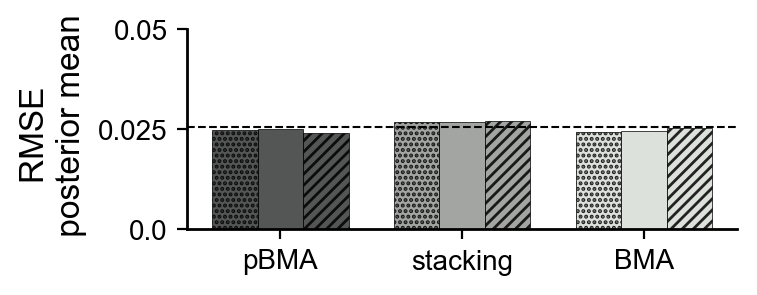

In [15]:
# Just models
RMSE_models_all = []
for i, name in enumerate(model_names_all):
    RMSE_models_all.append(np.sqrt(np.mean((np.mean(posterior_samples_all[i] - data.T, axis=0))**2)))

# MMI w/ all
RMSE_all = []

RMSE_all.append(np.sqrt(np.mean((np.mean(loo_pbma_combined_all - data.T, axis=0))**2)))
RMSE_all.append(np.sqrt(np.mean((np.mean(loo_stack_combined_all - data.T, axis=0))**2)))
RMSE_all.append(np.sqrt(np.mean((np.mean(loo_bma_combined_all - data.T, axis=0))**2)))

# MMI w/o best
RMSE_ExclGood = []

RMSE_ExclGood.append(np.sqrt(np.mean((np.mean(loo_pbma_combined_ExclGood - data.T, axis=0))**2)))
RMSE_ExclGood.append(np.sqrt(np.mean((np.mean(loo_stack_combined_ExclGood - data.T, axis=0))**2)))
RMSE_ExclGood.append(np.sqrt(np.mean((np.mean(loo_bma_combined_ExclGood - data.T, axis=0))**2)))

# MMI w/o worst
RMSE_ExclBad = []

RMSE_ExclBad.append(np.sqrt(np.mean((np.mean(loo_pbma_combined_ExclBad - data.T, axis=0))**2)))
RMSE_ExclBad.append(np.sqrt(np.mean((np.mean(loo_stack_combined_ExclBad - data.T, axis=0))**2)))
RMSE_ExclBad.append(np.sqrt(np.mean((np.mean(loo_bma_combined_ExclBad - data.T, axis=0))**2)))


# grouped bar chart
def make_grouped_bar(quant_list, xticklabels, colors,  hatch, ylabel, yticks,yticklabels,
                  line_qoi=None, width=2.5, height=1., bar_width=0.25):
    
    x = np.arange(len(xticklabels))  # the label locations
    multiplier = 0

    fig, ax = get_sized_fig_ax(width, height)
    for i in range(len(quant_list)):
        offset = bar_width * multiplier
        bar = ax.bar(x + offset, quant_list[i], bar_width, edgecolor='k', hatch=hatch[i], alpha=0.85)
        for j, br in enumerate(bar):
            br.set_facecolor(colors[j])
        multiplier += 1

    ax.set_xticks(x + bar_width, xticklabels)
    ax.set_ylabel(ylabel, fontsize=12.0)
    ax.set_xticklabels(xticklabels, rotation=0, fontsize=10.0)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels, fontsize=10.0)
    ax.set_ylim([min(yticks), max(yticks)])

    if line_qoi is not None:
        xlim = ax.get_xlim()
        ax.plot(xlim, line_qoi*np.array([1.,1.]), 'k--', linewidth=0.75)
        ax.set_xlim(xlim)
    
    return fig, ax

print(model_names_all[np.argmin(RMSE_models_all)])

f0, a0 = make_grouped_bar([RMSE_ExclBad, RMSE_all, RMSE_ExclGood], 
                          ['pBMA', 'stacking', 'BMA'], 
                          [colors[-3], colors[-2], colors[-1]],
                          ['......', None, '//////'], 'RMSE \n posterior mean', 
                          [0.0, 0.025, 0.05], ['0.0', '0.025', '0.05'],
                        line_qoi=min(RMSE_models_all), width=2.75, height=1.)
a0.set_ylim([0.0, 0.05])
a0.bar(np.nan, np.nan, color='w', edgecolor='k', hatch='......', label='exclude worst model')
a0.bar(np.nan, np.nan, color='w', edgecolor='k', hatch=None, label='all models')
a0.bar(np.nan, np.nan, color='w', edgecolor='k', hatch='//////', label='exclude best model')
leg = a0.legend(loc='upper left', fontsize=8.0, bbox_to_anchor=(2.0, 1.0), ncol=1)
export_legend(leg, '../../../results/MAPK/mmi/HF96_DR/mmi_RMSE_legend.pdf')
leg.remove()

f0.savefig(fig_dir + 'mmi_RMSE.pdf', transparent=True)

# export data to csv
rmse_df = pd.DataFrame({
    'exclude_bad': {model:RMSE_ExclBad[i] for i, model in enumerate(['pBMA', 'stacking', 'BMA'])},
    'exclude_good': {model:RMSE_ExclGood[i] for i, model in enumerate(['pBMA', 'stacking', 'BMA'])},
    'all': {model:RMSE_all[i] for i, model in enumerate(['pBMA', 'stacking', 'BMA'])}
}).T
rmse_df.to_csv(fig_dir + 'mmi_RMSE.csv', index=True)

In [16]:
# compute percent change in RMSE due to removing the best model compared to error of the worst model
worst_error = max(RMSE_models_all)
print('Worst model:', model_names_all[np.argmax(RMSE_models_all)])
print('Worst model error:', worst_error)
RMSE_change_best = ((np.array(RMSE_ExclGood) - np.array(RMSE_all))/(worst_error*np.ones_like(RMSE_all)))*100
print('RMSE change due to removing best model:', RMSE_change_best)

Worst model: ryu_2015
Worst model error: 0.05233581176972939
RMSE change due to removing best model: [-1.613741    0.14960955  1.71803052]


## Compute Posterior Uncertainty for all MMI preds

orton_2009


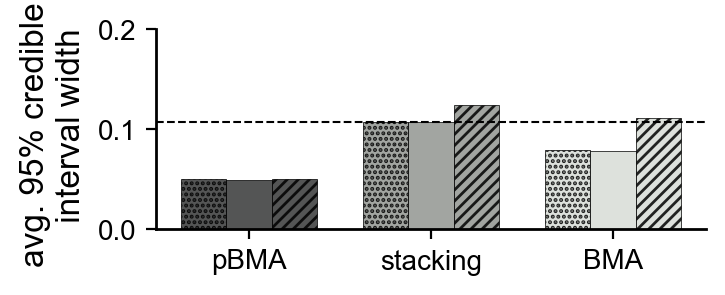

In [17]:

# Just models
uncert_95_models_all = []
for i, name in enumerate(model_names_all):
    uncert_95_models_all.append(np.mean(np.diff(np.quantile(posterior_samples_all[i], [0.025, 0.975], axis=0), axis=0)))

# MMI w/ all
uncert_95_all = []

uncert_95_all.append(np.mean(np.diff(np.quantile(loo_pbma_combined_all, [0.025, 0.975], axis=0), axis=0)))
uncert_95_all.append(np.mean(np.diff(np.quantile(loo_stack_combined_all, [0.025, 0.975], axis=0), axis=0)))
uncert_95_all.append(np.mean(np.diff(np.quantile(loo_bma_combined_all, [0.025, 0.975], axis=0), axis=0)))

# MMI w/o best
uncert_95_ExclGood = []

uncert_95_ExclGood.append(np.mean(np.diff(np.quantile(loo_pbma_combined_ExclGood, [0.025, 0.975], axis=0), axis=0)))
uncert_95_ExclGood.append(np.mean(np.diff(np.quantile(loo_stack_combined_ExclGood, [0.025, 0.975], axis=0), axis=0)))
uncert_95_ExclGood.append(np.mean(np.diff(np.quantile(loo_bma_combined_ExclGood, [0.025, 0.975], axis=0), axis=0)))

# MMI w/o worst
uncert_95_ExclBad = []

uncert_95_ExclBad.append(np.mean(np.diff(np.quantile(loo_pbma_combined_ExclBad, [0.025, 0.975], axis=0), axis=0)))
uncert_95_ExclBad.append(np.mean(np.diff(np.quantile(loo_stack_combined_ExclBad, [0.025, 0.975], axis=0), axis=0)))
uncert_95_ExclBad.append(np.mean(np.diff(np.quantile(loo_bma_combined_ExclBad, [0.025, 0.975], axis=0), axis=0)))

f3, a3 = make_grouped_bar([uncert_95_ExclBad, uncert_95_all, uncert_95_ExclGood], 
                          ['pBMA', 'stacking', 'BMA'], 
                          [colors[-3], colors[-2], colors[-1]],
                          ['......', None, '//////'], 'avg. 95% credible \n interval width',
                          [0.0, 0.1, 0.2], ['0.0', '0.1', '0.2'],
                        line_qoi=min(uncert_95_models_all), width=2.75, height=1.)

print(model_names_all[np.argmin(uncert_95_models_all)])

f3.savefig(fig_dir + 'mmi_uncert_95.pdf', transparent=True)

# export data to csv
uncert_df = pd.DataFrame({
    'exclude_bad': {model:uncert_95_ExclBad[i] for i, model in enumerate(['pBMA', 'stacking', 'BMA'])},
    'exclude_good': {model:uncert_95_ExclGood[i] for i, model in enumerate(['pBMA', 'stacking', 'BMA'])},
    'all': {model:uncert_95_all[i] for i, model in enumerate(['pBMA', 'stacking', 'BMA'])}
}).T
uncert_df.to_csv(fig_dir + 'mmi_uncert_95.csv', index=True)